#### Model taken from:
- Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

In [ ]:
# TODO - make sure all parameters (vessel and pipe) are in the same reference frame, e.g p.78, p.142
# TODO - applied top tension in dynamic case might have been time varying, Jensen thesis p.76-77
# TODO - verify results against the catenary
# TODO - roller reaction (force) should be proportional to pipe vertical displacement at rollers?
# TODO - do I have stinger accounted in the model? do I need stinger in the model?, see 3338.pdf
# TODO - do I have seabed interaction force in the model?
# TODO - add more nodes

In [1]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from scipy.integrate import ode
from scipy.misc import derivative
from numpy.linalg import inv, pinv
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

### Inputs

In [4]:
pipe_joint_length = 250 #600 #100 # [m]
pipe_weight_per_unit_length = 96 #  (submerged) [kg/m]  # 113.07 - not submerged

q = [45, 20, -15, -5] # used for initial checks only but not in final solution 
l = [pipe_joint_length for i in range(len(q))]

# mn = 5.08976 * 10e7 # mass of the vessel, [kg]
# In = 5.041*10e7 # moment of inertia of the vessel, [kg*𝑚2]
# mn = 80048 # mass of the vessel, [kg]
# In = 50410 # moment of inertia of the vessel, [kg*𝑚2]

mn = 32219000 # mass of the vessel, [kg]
# mn = 5.08976 *1e7 # mass of the vessel, [kg]

In [5]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]
# L = 240 # [m]
# Xg = 120 # [m]

In [6]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [7]:
In = vessel_inertia_moment(mn,Xg,L)

In [8]:
In

253533324687.5

In [9]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [10]:
# for hydrodynamic damping matrix
Cd=[0.87, 0.87, 0.87, 1.6] # Drag coefficient
# Cd=0.82 # Drag coefficient

qw = 1025 # Water density [kg/m3]
d0 = 0.7610 # Outer diameter of pipe, [m]
dI= 0.69# Inner diameter of pipe, [m]

In [11]:
# for vector of spring forces in the pipe joints
# K = 1.4*10e11
E = 210e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

K = EI#10e7 # depends on the unit bending stiffness of the pipe (EI), 
       # and the length li, of the link; from the Jensen thesis [N/m]

In [12]:
K

1120051921.710554

In [13]:
# for vector of control inputs
tau_qn = 250576 # tension in pipe at water level, [N] (check Jee sheets)
Fx_ = 7.5e7 # 5e7 # [N], from the Jensen thesis
# Fy=-100*1000 # [N],

In [14]:
# for solution
max_t = 600  
dt = 0.5
t=np.arange(0,max_t,dt)
# q0=[45, 0, 20, 0, 15, 0, 5, 0]

In [15]:
Awp = 1000 # the waterplane area of the vessel, [m^2]
# h=26.3 # water depth, [m]
h=700

# fip=1e10
fip=1e12

In [16]:
kd=0.5e5
kp=0.95e5

### System inertia matrix 

In [17]:
def alpha(i, q):
    return sum(q[:i+1])
    
def Jv(q, i, l):

    def Jv0(i, k, q, l):
        if k<i:
            tmp1=0
            for j in range(k, i):
                tmp1+=l[j]*math.sin(math.radians(alpha(j,q)))
            tmp1=-tmp1-0.5*l[i]*math.sin(math.radians(alpha(i,q)))  

            tmp2=0
            for j in range(k, i):
                tmp2+=l[j]*math.cos(math.radians(alpha(j,q)))
            tmp2=tmp2+0.5*l[i]*math.cos(math.radians(alpha(i,q))) 

            return np.array([tmp1, tmp2]).T

        elif k==i:
            return np.array([-0.5*l[i]*math.sin(math.radians(alpha(i,q))),
                    0.5*l[i]*math.cos(math.radians(alpha(i,q)))]).T
        else:
            return np.array([0, 0]).T
    
    ans=np.array([Jv0(i, k, q, l) for k in range(len(q))])
    
    return ans.T

def Jomega(i):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [18]:
def M(q, l, mn, In, mi):
    
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
 
    sum2 = In * np.dot(Jomega(len(q)-1).T, Jomega(len(q)-1))
    
    sum3=0
    for i in range(len(q)-1):
        sum3+=mi[i]*np.dot(Jv(q, i, l).T, Jv( q,i, l))
      
    return sum1 + sum2 + sum3   

In [19]:
M(q, l, mn, In, mi)

array([[2.44094638e+13, 1.74844240e+13, 1.06825791e+13, 3.71293500e+12],
       [1.74844240e+13, 1.25764467e+13, 7.66896336e+12, 2.70609125e+12],
       [1.06825791e+13, 7.66896336e+12, 4.77704251e+12, 1.75996761e+12],
       [3.71293500e+12, 2.70609125e+12, 1.75996761e+12, 7.56955200e+11]])

### Coriolis-centripetal matrix

In [20]:
# TODO - not sure about this formula 
def C(q, dq, l, mn, In, mi): #here
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    dq1_, dq2_, dq3_, dq4_ = Dfun(q)
    diff = [dq1_, dq2_, dq3_, dq4_]
    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*np.radians(dq[k])
    return ans                

In [21]:
dq=[1,1,0.5,1]
C(q, dq, l, mn, In, mi)

array([[ 1.23064698e-04,  4.08639393e+08, -5.52222172e+08,
        -3.68662917e+08],
       [-8.17278785e+08, -1.31756329e+08, -6.72555814e+08,
        -3.68662917e+08],
       [ 1.10444434e+09,  1.26488920e+09,  2.36977346e+08,
         2.47057519e+07],
       [ 7.37325834e+08,  7.37325834e+08,  2.65283431e+08,
         1.38311878e+08]])

### Hydrodynamic damping matrix

In [22]:
def R_I_Bi(i, q):
    return np.array([[math.cos(math.radians(alpha(i,q))), -math.sin(math.radians(alpha(i,q)))],
                    [math.sin(math.radians(alpha(i,q))), math.cos(math.radians(alpha(i,q)))]])

In [23]:
I_=np.array([[0,0],
             [0,1]])

In [24]:
def Pi(i,q):
    return np.dot(np.dot(R_I_Bi(i, q),I_),R_I_Bi(i, q).T)

In [25]:
# TODO - not sure about this formula 
def mod_Vn(q,dq):
    ans=[]
    for j in range(len(q)):
        ans.append(np.dot(np.dot(Pi(j,q),Jv( q,j, l)), np.radians(dq)))
    return np.linalg.norm(np.array(ans))

In [26]:
mod_Vn(q,dq)

37.06541063716255

In [27]:
# TODO - not sure about this formula 
def mod_Vni(i,q,dq):
    return np.linalg.norm(np.dot(np.dot(Pi(i,q),Jv( q,i, l)), np.radians(dq)))

In [28]:
mod_Vni(len(q)-1,q,dq)

31.066302122547715

In [29]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [30]:
def H(q,dq,l):
    ans=np.zeros((len(q), len(q)))
    
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,q)),Jv( q,j, l))
    return ans    

In [31]:
H(q,[0,0,0,0.1],l)

array([[2.51121410e+10, 1.78033620e+10, 1.09353563e+10, 3.65438949e+09],
       [1.78033620e+10, 1.26217712e+10, 7.75266863e+09, 2.59079538e+09],
       [1.09353563e+10, 7.75266863e+09, 4.76192048e+09, 1.59134386e+09],
       [3.65438949e+09, 2.59079538e+09, 1.59134386e+09, 5.31797051e+08]])

### Vector of spring forces in the pipe joints

In [32]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [33]:
def x(q,i,l):
    tmp1=0
    for j in range(i):
        tmp1+=l[j]*math.cos(math.radians(alpha(j,q)))
    tmp1+=0.5*l[i]*math.cos(math.radians(alpha(i,q)))
    return tmp1

In [34]:
def y(q,i,l):
    tmp1=0
    for j in range(i):
        tmp1+=l[j]*math.sin(math.radians(alpha(j,q)))
    tmp1+=0.5*l[i]*math.sin(math.radians(alpha(i,q)))
    return tmp1

In [35]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 

# not complete formula
def gt(q,fip, i): 
    return -fip*math.radians(alpha(i, q))


In [36]:
# TODO understand the commeted part and incorporate it in model 
def g(q):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i))    
    tmp = -qw*Awp*(y(q,len(q)-1,l)-h)*G 
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp)  #- \
#         np.dot(Jomega(len(q)-1).T, gt(q, fip, len(q)-1)).reshape(len(q),) 
    return sum_.reshape(len(q),1)   

In [37]:
g(q)

array([[-8.88866220e+10],
       [-5.95194431e+10],
       [-4.18716214e+10],
       [-1.48840905e+10]])

### Vector of control inputs

In [38]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans
# tau_q - control forces from the stinger 

In [39]:
def Fx(q,dq,kp, kd, x_ref = 0):
#     print(-kp*(x(q,len(q)-1,l)-x_ref))
#     return -kp*(x(q,len(q)-1,l)-x_ref) - kd*np.dot(np.dot(Pi(len(q)-1,q),Jv( q, len(q)-1, l)), np.radians(dq)) 
    return -kp*(x(q,len(q)-1,l)-x_ref) - kd*mod_Vn(q,dq)

In [40]:
Fx(q,dq,kp, kd, x_ref = 0)

-52347339.05802581

In [41]:
F1=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
# F=np.array([0,Fy]).reshape(2,1)
def tau_t(q, F):
    tmp= np.dot(Jv(q,len(q)-1, l).T, F)
    return tmp
#     ans=np.zeros((len(q),1))
#     ans[-1][0]=tmp[-1][0]
#     return  ans # the thruster forces

In [42]:
tau_t(q, F1)

array([[-5.12439825e+10],
       [-3.79857304e+10],
       [-2.09924594e+10],
       [-6.62912607e+09]])

In [43]:
tau_q_wave=9e6 # (taken from article on forces to semi-submersible platform),[N]
# this function purly my invention
# TODO - for improvement see Jensen thesis p. 49
def tau_wave(q, tau_q_wave):
    ans= np.array([tau_q_wave*(i+1)/(10*len(q)) for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_q_wave
    return ans

In [44]:
def tau(q, tau_qn, F, tau_q_wave):
#     return tau_q(q,tau_qn) + tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return  tau_t(q, F)
    return tau_t(q, F) + tau_wave(q, tau_q_wave)

In [45]:
tau_wave(q, tau_q_wave)

array([[ 225000.],
       [ 450000.],
       [ 675000.],
       [9000000.]])

### Static solution

In [46]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [47]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [48]:
lift_off_slope = 30.6 # from Jee catenary sheet, [deg]

In [49]:
# Fx_=250000 # [N]

In [50]:
horizontal_length =(Fx_/Ws)*math.asinh(math.tan(math.radians(lift_off_slope)))

In [51]:
horizontal_length

44711.635519269585

In [52]:
number_of_elements=4

In [53]:
delta_x=horizontal_length/number_of_elements

In [54]:
x0=[i*delta_x for i in range(number_of_elements+1)]
y0=[]
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [55]:
x0

[0.0,
 11177.908879817396,
 22355.817759634792,
 33533.72663945219,
 44711.635519269585]

In [56]:
q=[]
l_=[]
deg_=[0]
for i in range(len(x0)-1):
    l_.append(math.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    deg =math.degrees(math.atan((y0[i+1]-y0[i])/(x0[i+1]-x0[i])))
    q.append(deg-deg_[-1]) 
    deg_.append(deg)

In [57]:
q

[4.020973809418599, 7.963378805032683, 7.735172209845448, 7.378145779801677]

In [58]:
l_

[11205.49177797705, 11426.967117302982, 11874.267995654049, 12556.184638984565]

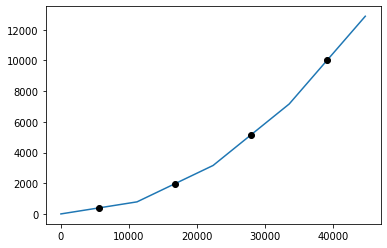

In [59]:
plt.plot(x0, y0)
plt.plot(x(q,0,l_),y(q,0,l_), 'o', color='black')
plt.plot(x(q,1,l_),y(q,1,l_), 'o', color='black')
plt.plot(x(q,2,l_),y(q,2,l_), 'o', color='black')
plt.plot(x(q,3,l_),y(q,3,l_), 'o', color='black')
plt.show()

In [60]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [61]:
q0

[4.020973809418599,
 0,
 7.963378805032683,
 0,
 7.735172209845448,
 0,
 7.378145779801677,
 0]

In [62]:
F_=np.array([-Fx(q,dq,kp, 0, x_ref = 0),0]).reshape(2,1)

In [63]:
F_

array([[79852584.21874917],
       [       0.        ]])

In [64]:
def static_func(q):
    ans=  f(q, K) + g(q) - tau(q, tau_qn, F_, 0)
    return ans.reshape((len(q),))

In [65]:
root = fsolve(static_func, np.array(q))

In [66]:
root

array([37.54354667, 16.24300572,  6.53963927,  1.74427052])

In [67]:
q=list(root)

In [68]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

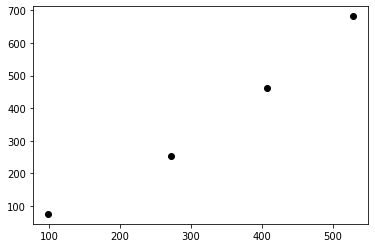

In [69]:
plt.plot(x(q,0,l),y(q,0,l), 'o', color='black')
plt.plot(x(q,1,l),y(q,1,l), 'o', color='black')
plt.plot(x(q,2,l),y(q,2,l), 'o', color='black')
plt.plot(x(q,3,l),y(q,3,l), 'o', color='black')
plt.show()

In [70]:
q

[37.54354666797212, 16.243005721243314, 6.539639274525555, 1.7442705227576503]

In [71]:
q0

[37.54354666797212,
 0,
 16.243005721243314,
 0,
 6.539639274525555,
 0,
 1.7442705227576503,
 0]

In [72]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.002052


In [73]:
tmp__1=pinv(add1__Jv.transpose(0, 2, 1))
tmp__2= add5__f + add6__g

In [74]:
tmp__=np.matmul(tmp__1, tmp__2)

In [75]:
dim1=int(max_t/dt)
dim2=dim1-1

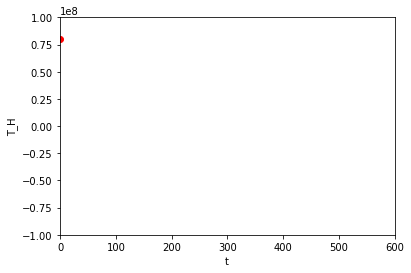

In [76]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

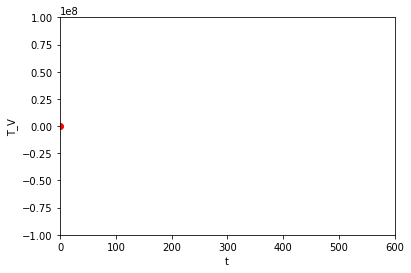

In [77]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'o', color='red')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [78]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([79852584.21935432]), array([-0.0006023]))

### Dynamic solution 

In [79]:
from scipy.linalg import lu_factor, lu_solve

In [80]:
def manipulator(Q, t, q):
    q0,dq0,q1,dq1,q2,dq2,q3,dq3 = Q
    QI=np.array([q0,q1,q2,q3]).reshape(len(q),1)
    dQ=np.array([dq0,dq1,dq2,dq3]).reshape(len(q),1)
    if t>100:
        F=np.array([-Fx(QI, dQ, kp, kd, x_ref = 0),0]).reshape(2,1)
    else:
        F=np.array([Fx_,0]).reshape(2,1)
    ddq0,ddq1,ddq2,ddq3 = np.linalg.lstsq(M(QI, l, mn, In, mi), 
                        - np.dot(H(QI,dQ,l), np.radians(dQ)).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), np.radians(dQ)).reshape(len(QI),1)  
                        - f(QI, K) 
                        - g(QI)
                        + tau(QI, tau_qn, F, tau_q_wave), rcond=None)[0]
    return [dq0,ddq0,dq1,ddq1,dq2,ddq2,dq3,ddq3]

In [81]:
startTime1 = datetime.now()
us=odeint(manipulator,q0,t, args=(q,))
print(datetime.now() - startTime1)

0:34:29.886877


In [82]:
us_=us

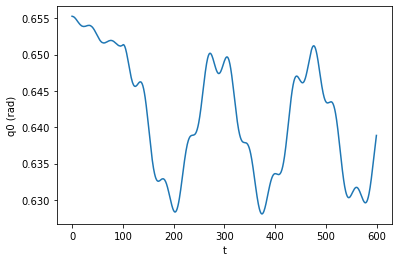

In [83]:
plt.plot(t,np.radians(us_[:,0]) ,'-')
plt.xlabel('t')
plt.ylabel('q0 (rad)')
plt.show()

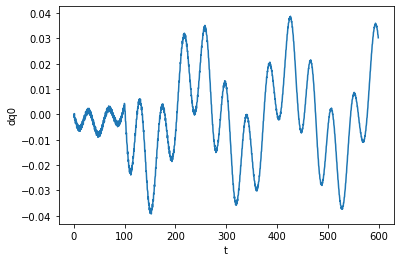

In [84]:
plt.plot(t,us_[:,1],'-')
plt.xlabel('t')
plt.ylabel('dq0')
plt.show()

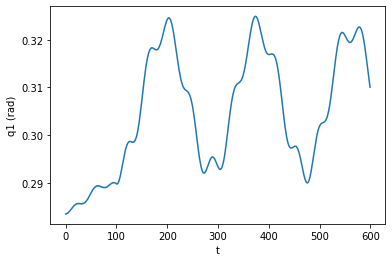

In [85]:
plt.plot(t, np.radians(us_[:,2]),'-')
plt.xlabel('t')
plt.ylabel('q1 (rad)')
plt.show()

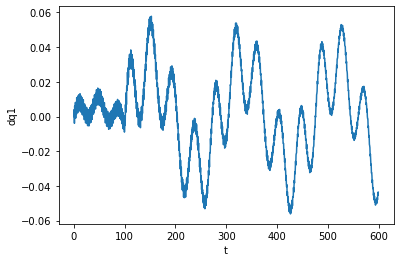

In [86]:
plt.plot(t, us_[:,3],'-')
plt.xlabel('t')
plt.ylabel('dq1')
plt.show()

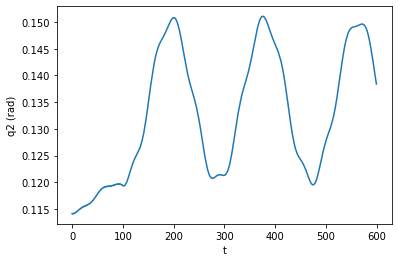

In [87]:
plt.plot(t, np.radians(us_[:,4]),'-')
plt.xlabel('t')
plt.ylabel('q2 (rad)')
plt.show()

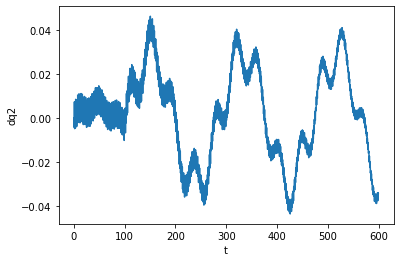

In [88]:
plt.plot(t, us_[:,5],'-')
plt.xlabel('t')
plt.ylabel('dq2')
plt.show()

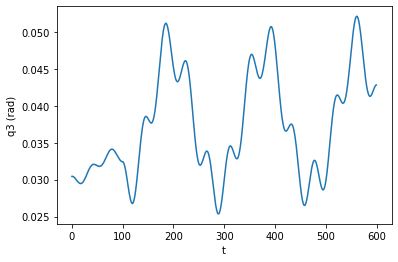

In [89]:
plt.plot(t, np.radians(us_[:,6]),'-')
plt.xlabel('t')
plt.ylabel('q3 (rad)')
plt.show()

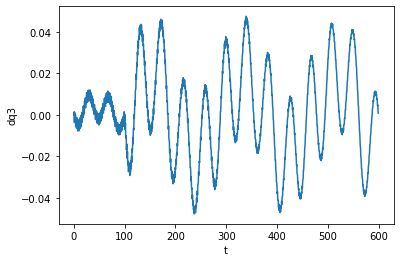

In [90]:
plt.plot(t, us_[:,7],'-')
plt.xlabel('t')
plt.ylabel('dq3')
plt.show()

In [91]:
X0=[x(us_[i,[0,2,4,6]],0,l) for i in range(len(us_))]
Y0=[y(us_[i,[0,2,4,6]],0,l) for i in range(len(us_))]
X1=[x(us_[i,[0,2,4,6]],1,l) for i in range(len(us_))]
Y1=[y(us_[i,[0,2,4,6]],1,l) for i in range(len(us_))]
X2=[x(us_[i,[0,2,4,6]],2,l) for i in range(len(us_))]
Y2=[y(us_[i,[0,2,4,6]],2,l) for i in range(len(us_))]
X3=[x(us_[i,[0,2,4,6]],3,l) for i in range(len(us_))]
Y3=[y(us_[i,[0,2,4,6]],3,l) for i in range(len(us_))]

In [92]:
X0_=[x(us_[i,[0,2,4,6]],0,l) for i in range(1)]
Y0_=[y(us_[i,[0,2,4,6]],0,l) for i in range(1)]
X1_=[x(us_[i,[0,2,4,6]],1,l) for i in range(1)]
Y1_=[y(us_[i,[0,2,4,6]],1,l) for i in range(1)]
X2_=[x(us_[i,[0,2,4,6]],2,l) for i in range(1)]
Y2_=[y(us_[i,[0,2,4,6]],2,l) for i in range(1)]
X3_=[x(us_[i,[0,2,4,6]],3,l) for i in range(1)]
Y3_=[y(us_[i,[0,2,4,6]],3,l) for i in range(1)]

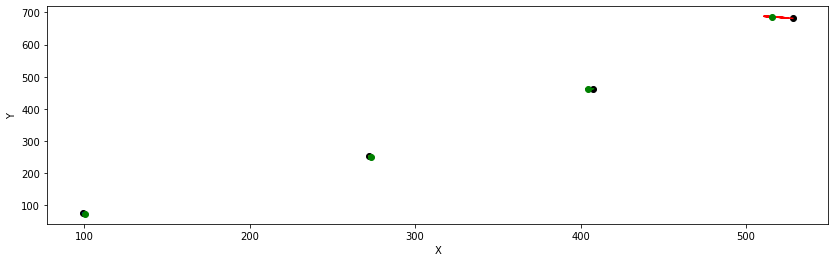

In [93]:
plt.figure(figsize=(14,4))
plt.plot(X0_,Y0_, 'o', color='black')
plt.plot(X1_,Y1_, 'o', color='black')
plt.plot(X2_,Y2_, 'o', color='black')
plt.plot(X3_,Y3_, 'o', color='black')

# dynamic
plt.plot(X0,Y0,'b')
plt.plot(X1,Y1,'y')
plt.plot(X2,Y2,'g')
plt.plot(X3,Y3,'r')

plt.plot(x(us_[-1,[0,2,4,6]],0,l),y(us_[-1,[0,2,4,6]],0,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6]],1,l),y(us_[-1,[0,2,4,6]],1,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6]],2,l),y(us_[-1,[0,2,4,6]],2,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6]],3,l),y(us_[-1,[0,2,4,6]],3,l), 'o', color='green')

# plt.plot(x0, y0)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [94]:
us_[0,0]

37.54354666797212

In [95]:
us_[0,2]

16.243005721243314

In [96]:
us_[0,4]

6.539639274525555

In [97]:
us_[0,6]

1.7442705227576503

In [98]:
us_[0,0]+us_[0,2]+us_[0,4]+us_[0,6]

62.070462186498645

### Pipe-tip tension

In [99]:
coordinates=us[:,[0,2,4,6]]
velocities=us[:,[1,3,5,7]]

In [100]:
velocities.shape

(1200, 4)

In [101]:
velocities_0=velocities[:-1]
velocities_1=velocities[1:]

In [102]:
coordinates.shape, velocities.shape

((1200, 4), (1200, 4))

In [103]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

0:01:10.907527


In [104]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H, l=l)
add3__H =np.array(list(map(add3, coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates)))

print(datetime.now() - startTime)

0:00:01.682508


In [105]:
velocities_1.shape

(1199, 4)

In [106]:
tmp__1=pinv(add1__Jv[:-1].transpose(0, 2, 1))
#here
tmp__2=np.matmul(add2__M[:-1], ((np.radians(velocities_1).reshape(dim2,4,1) - 
                              np.radians(velocities_0).reshape(dim2,4,1))/dt))\
            + np.matmul(add3__H[:-1], np.radians(velocities[:-1]).reshape(dim2,4,1)) \
            + np.matmul(add4__C[:-1], np.radians(velocities[:-1]).reshape(dim2,4,1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [107]:
tmp__=np.matmul(tmp__1, tmp__2)

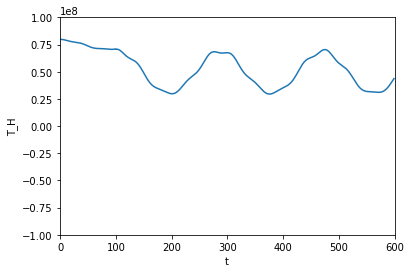

In [108]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'-')
plt.xlim([-1, dim1//2])
plt.ylim([-100000000, 100000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

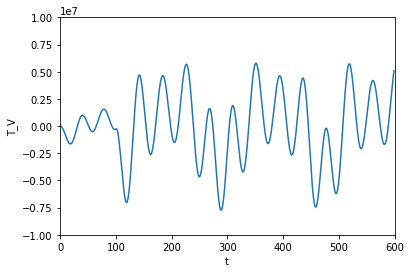

In [109]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'-')
plt.xlim([-1, dim1//2])
plt.ylim([-10000000, 10000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [110]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([79768238.57731925]), array([5783085.63726778]))

In [111]:
min(tmp__[:,0]), min(tmp__[:,1])

(array([29460304.11782245]), array([-7737589.41654721]))

In [112]:
# (array([28319143.73486871]), array([25605994.71854329])) just waves
# (array([28491881.95694733]), array([25520818.9120822]))  positive Fx
# (array([28146301.99196166]), array([25687403.50463529])) negative Fx
# (array([30076743.25808775]), array([25019302.28641659])) large positive Fx
# (array([26618614.2824719]),  array([26179692.06953637])) large negative Fx
# (array([3953150.66297572]),  array([1508270.46574422]))  fip=1e10
# (array([6746771.13788591]),  array([10057989.37909701])) max_t = 300
# (array([2084853.78862965]),  array([766900.49862976])) fip=1e9
# (array([1518705.92013393]),  array([361011.0471009])) fip=5e8
# (array([2212275.89406135]),  array([634267.05259892])) fip=4e8

In [113]:
# ρa = 1.200 * 10**3 # g/m3
# ρs=7.850 * 10**6
# di = 0.6900 # m
# do = 0.7610 

In [114]:
# Q=(ρa-ρs)*(di/do)**2+ρs  # g/m3

In [115]:
# length=1000

In [116]:
# V=math.pi * (do/2)**2 * length - math.pi * (di/2)**2 * length #m3

In [117]:
#m3

In [118]:
# Q*V/length/1000